In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from faker_dataset import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
num_samples = 100000
dataset = create_dataset(num_samples=num_samples)
save_dataset_to_csv(dataset=dataset, file_name="../datasets/sensitive_data.csv")

In [3]:
dataset

[('Next environment thousand administration pull reveal side itself issue likely still old business relationship good focus hair like according.',
  'None',
  0),
 ('Term health pass teacher prevent community account offer professor state young society international.',
  'None',
  0),
 ('Skin pattern commercial audience give check phone land.', 'None', 0),
 ('Great air away it 05532 816757 send usually become agreement sometimes several policy a feel throw space discover.',
  'phone',
  1),
 ('Shake structure everybody thousand ok generation mouth wind key others simple that never.',
  'None',
  0),
 ('Range goal moment 0141333649 build get artist brother house ready add food.',
  'phone',
  1),
 ('Side now where must song art pattern summer attorney forget stay.',
  'None',
  0),
 ('Feeling increase pick marriage everything discuss when within food past turn people hear hour despite win.',
  'None',
  0),
 ('Trouble great small camera author free marriage sound.', 'None', 0),
 ('Place

# Data analysis

Choice Distribution:
None: 50109 (50.11%)
phone: 14813 (14.81%)
address: 14980 (14.98%)
email: 15032 (15.03%)
phone_address: 1548 (1.55%)
address_email: 1491 (1.49%)
phone_email: 1513 (1.51%)
all_three: 514 (0.51%)


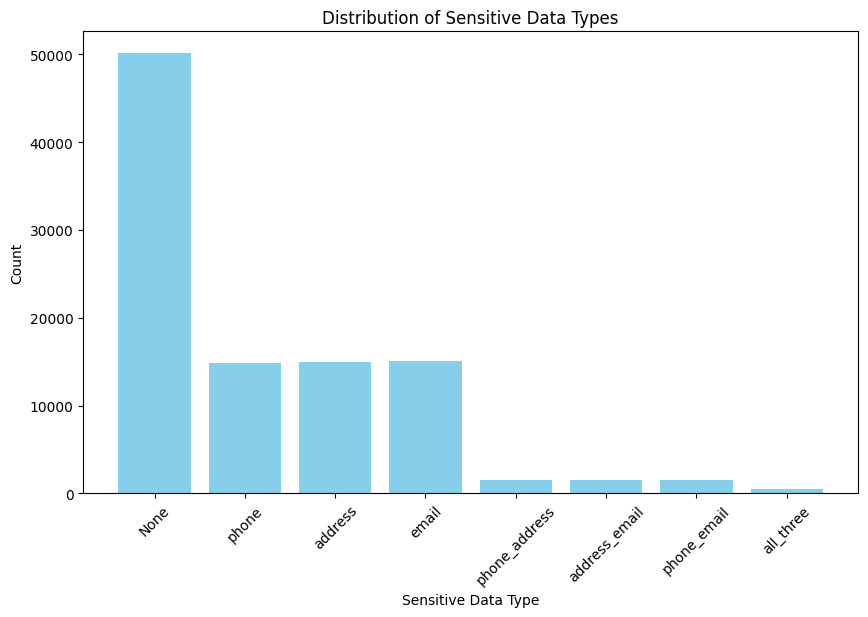

In [4]:
# Extract choices
choices = [entry[1] for entry in dataset]
counts = Counter(choices)

# Print counts
print("Choice Distribution:")
for choice, count in counts.items():
    print(f"{choice}: {count} ({(count / len(dataset)) * 100:.2f}%)")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.title("Distribution of Sensitive Data Types")
plt.xlabel("Sensitive Data Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Sensitive Messages: 49891 (49.89%)
Non-Sensitive Messages: 50109 (50.11%)


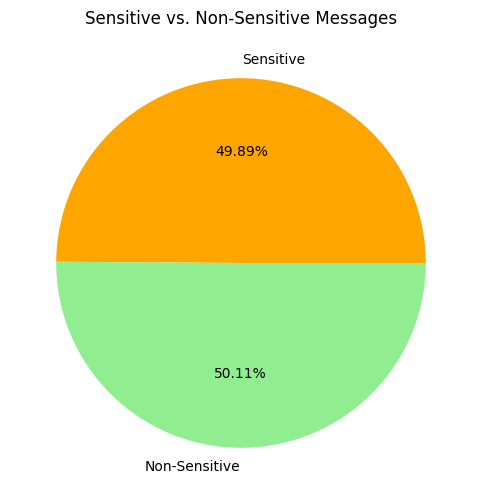

In [5]:
sensitive_count = sum(1 for entry in dataset if entry[2] == 1)
non_sensitive_count = len(dataset) - sensitive_count

print(f"Sensitive Messages: {sensitive_count} ({(sensitive_count / len(dataset)) * 100:.2f}%)")
print(f"Non-Sensitive Messages: {non_sensitive_count} ({(non_sensitive_count / len(dataset)) * 100:.2f}%)")

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [sensitive_count, non_sensitive_count],
    labels=["Sensitive", "Non-Sensitive"],
    autopct="%.2f%%",
    colors=["orange", "lightgreen"]
)
plt.title("Sensitive vs. Non-Sensitive Messages")
plt.show()

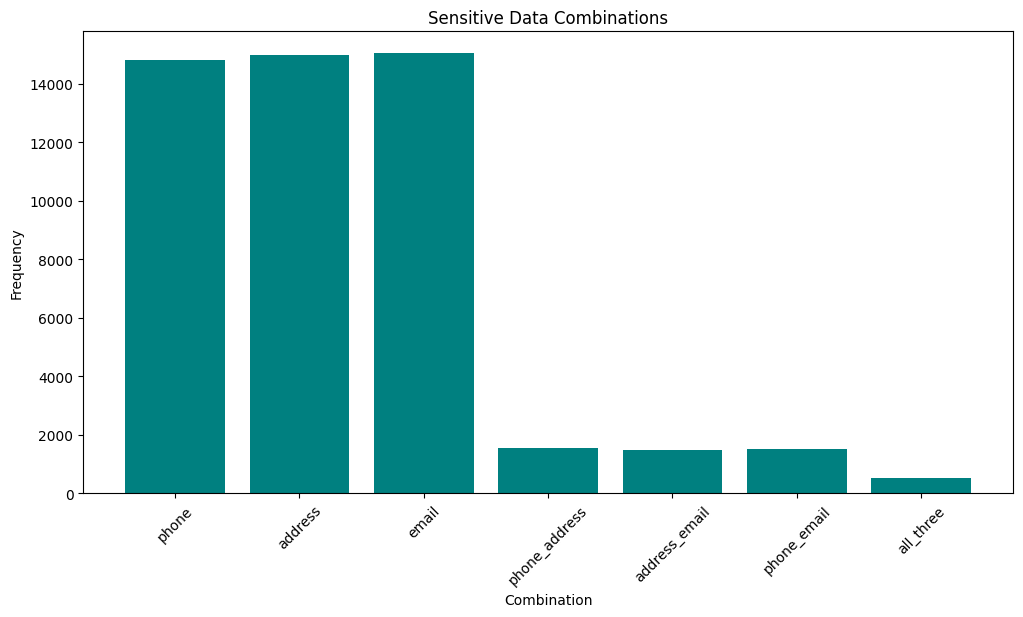

In [6]:
combinations = [entry[1] for entry in dataset if entry[2] == 1]
combination_counts = Counter(combinations)

# Prepare data for heatmap
keys = combination_counts.keys()
values = combination_counts.values()

plt.figure(figsize=(12, 6))
plt.bar(keys, values, color='teal')
plt.title("Sensitive Data Combinations")
plt.xlabel("Combination")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Machine Learning

In [7]:
# Convert to a DataFrame for easy handling
df = pd.DataFrame(dataset, columns=["message", "choice", "contains_sensitive"])

# Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["contains_sensitive"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["contains_sensitive"])

In [8]:
# Summary of the splits
print("Train DataFrame:", train_df.shape)
print("Validation DataFrame:", val_df.shape)
print("Test DataFrame:", test_df.shape)

# Summary of the splits
print("Train DataFrame:", train_df.head())
print("Validation DataFrame:", val_df.head())
print("Test DataFrame:", test_df.head())

Train DataFrame: (70000, 3)
Validation DataFrame: (15000, 3)
Test DataFrame: (15000, 3)
Train DataFrame:                                                  message         choice  \
90045          Imagine protect factor line chance these.           None   
88206              Central public single job about fire.           None   
43433  Room night 807 Neil Station Apt. 956\nNorth Ra...        address   
94718                 Central draw country need believe.           None   
28782  Worry candidate whose word ok. +33 (0)7 42 73 ...  phone_address   

       contains_sensitive  
90045                   0  
88206                   0  
43433                   1  
94718                   0  
28782                   1  
Validation DataFrame:                                                  message   choice  \
52770  Draw first away low hope card lot sport societ...    phone   
85335  Skill letter you wait himself son PSC 5895, Bo...  address   
60484  One beautiful few it win into alicegerma

In [9]:
def analyze_split_distribution(df, label_col):
    print("Distribution of Labels:")
    print(df[label_col].value_counts(normalize=True) * 100)
    print()

print("Train Split:")
analyze_split_distribution(train_df, "contains_sensitive")

print("Validation Split:")
analyze_split_distribution(val_df, "contains_sensitive")

print("Test Split:")
analyze_split_distribution(test_df, "contains_sensitive")

Train Split:
Distribution of Labels:
contains_sensitive
0    50.108571
1    49.891429
Name: proportion, dtype: float64

Validation Split:
Distribution of Labels:
contains_sensitive
0    50.106667
1    49.893333
Name: proportion, dtype: float64

Test Split:
Distribution of Labels:
contains_sensitive
0    50.113333
1    49.886667
Name: proportion, dtype: float64



In [10]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(train_df['message'])
X_val = vectorizer.transform(val_df['message'])
X_test = vectorizer.transform(test_df['message'])

# Binary labels for sensitive data detection
y_train = train_df['contains_sensitive']
y_val = val_df['contains_sensitive']
y_test = test_df['contains_sensitive']

In [11]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], 
    'solver': ['lbfgs']
}

lr_model = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, scoring='accuracy')
lr_model.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", lr_model.best_params_)
print("Validation Accuracy:", lr_model.score(X_val, y_val))

Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy: 0.9323333333333333


In [12]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 50, None],
    'min_samples_split': [2, 5],
}

rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
rf_model.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_model.best_params_)
print("Validation Accuracy:", rf_model.score(X_val, y_val))

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Validation Accuracy: 0.9254


In [13]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm_model = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='accuracy')
svm_model.fit(X_train, y_train)

print("Best SVM Parameters:", svm_model.best_params_)
print("Validation Accuracy:", svm_model.score(X_val, y_val))

Best SVM Parameters: {'C': 10, 'kernel': 'linear'}
Validation Accuracy: 0.933


In [14]:
# Logistic Regression
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Test Accuracy:", lr_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Test Accuracy:", rf_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# SVM
y_pred_svm = svm_model.predict(X_test)
print("SVM Test Accuracy:", svm_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Logistic Regression Test Accuracy: 0.9286666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      7517
           1       1.00      0.86      0.92      7483

    accuracy                           0.93     15000
   macro avg       0.94      0.93      0.93     15000
weighted avg       0.94      0.93      0.93     15000

Random Forest Test Accuracy: 0.9227333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93      7517
           1       0.99      0.85      0.92      7483

    accuracy                           0.92     15000
   macro avg       0.93      0.92      0.92     15000
weighted avg       0.93      0.92      0.92     15000

SVM Test Accuracy: 0.9306666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      7517
           1       1.00  

In [15]:
# Save the vectorizer --- TF-IDF
with open('../models/sensitive/sensitive_tfidf_vectorize.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save the trained model --- Logistic Regression
with open('../models/sensitive/sensitive_logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(lr_model, model_file)

# Save the trained model --- Random Forest
with open('../models/sensitive/sensitive_random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

# Save the trained model and vectorizer --- SVM
with open('../models/sensitive/sensitive_svm_model.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)